# Attendu du livrable


Il s'agit de votre présentation intégrant votre notebook Jupyter (qui sera envoyé la veille de la soutenance) et votre présentation de 20 minutes qui devra montrer l'ensemble de votre démarche :
* La génération de votre/vos jeux de données en justifiant les choix et les traitements effectués pour faire face aux problématiques classiques de ce type de travail.
* le choix de (des) l'algorithme(s) d'"IA" retenu(s).
* l'analyse des résultats obtenus et leur interprétation en s'appuyant sur des métriques.
* La démarche mise en œuvre pour améliorer un modèle.
* le choix du modèle retenu au final parmi les différents essais effectués en justifiant pas rapport au besoin de votre client et des métriques.
* vos propositions finales justifiées

### Récapitulation de l'étude éthique

Pour ce projet, nous allons utiliser un jeu de données modifié (cf. [Éthique des données](ethique_des_donnees.ipynb)) en fonction de la problématique éthique de l'utilisation des données et de l'IA. Il vérifie les différentes réglementations en vigueur (RGPD, CNIL, etc.) et respec les principes de l'éthique.

Pour définir si ce jeu de données est suffisant même emputé de ses données non éthiques, nous allons faire le même traitement que pour le jeu de données original.

# Acquisition des données


Collecter des données brutes à partir de diverses sources, telles que des capteurs, des fichiers, des bases de données, etc.


In [1]:
import pandas as pd
import numpy as np
import os
from copy import deepcopy

# Settings
pd.set_option('display.max_columns', None)

# Global variables
GENERAL_DATA_PATH = "./data/general_data.csv"
EMPLOYEE_SURVEY_DATA_PATH = "./data/employee_survey_data.csv"
MANAGER_SURVEY_DATA_PATH = "./data/manager_survey_data.csv"
IN_TIME_DATA_PATH = "./data/in_out_time/in_time.csv"
OUT_TIME_DATA_PATH = "./data/in_out_time/out_time.csv"


In [2]:
def agregate_dataframes(list_df: list, on_column: str, how: str) -> pd.DataFrame:
    '''
    Merge dataframes.

    Parameters
    ----------
    list_df : list
        List of dataframes to merge.
    on_column : str
        Column to merge on.
    how : str
        Type of merge.

    Returns
    -------
    df_master : pandas.DataFrame
        Dataframe with all dataframes merged.

    Example
    -------
    >>> df1 = pd.DataFrame({"A": [1, 2, 3], "B": [4, 5, 6]})
    >>> df2 = pd.DataFrame({"A": [1, 2, 3], "C": [7, 8, 9]})
    >>> df3 = pd.DataFrame({"A": [1, 2, 3], "D": [10, 11, 12]})
    >>> df_master = agregate_dataframes([df1, df2, df3], "A", "outer")
    >>> df_master
        A    B    C     D
    0  1.0  4.0  7.0  10.0
    1  2.0  5.0  8.0  11.0
    2  3.0  6.0  9.0  12.0
    '''
    df_master = list_df[0]
    for df in list_df[1:]:
        df_master = df_master.merge(df,
                                    on=on_column,
                                    how=how)
    return df_master


def avg_time(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Calculate the average time of in_time and out_time.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe with in_time or out_time.

    Returns
    -------
    df : pandas.DataFrame
        Dataframe with EmployeeID and AvgTime.

    Example
    -------
    >>> df = pd.DataFrame({"EmployeeID": [1, 2, 3], "InTime": ["2020-01-01 08:00:00", "2020-01-01 08:00:00", "2020-01-01 08:00:00"]})
    >>> df = avg_time(df)
    >>> df
        EmployeeID   AvgTime
    0           1  08:00:00
    1           2  08:00:00
    2           3  08:00:00
    '''
    # Set first column as index
    df = df.copy().set_index(df.columns[0])
    # Remove first column
    df = df.copy().transpose()

    # Convert datetime to normalized time format
    df = df.apply(pd.to_datetime)
    df = df.apply(lambda x: x - x.dt.normalize())
    df = df.mean(skipna=True)
    # Add column EmployeeID
    df = df.to_frame().reset_index()
    df.columns = ["EmployeeID", "AvgTime"]
    return df


### Informations sur des données brutes

Cette partie a pour but de visualiser la structure les données brutes pour comprendre de quoi il s'agit et voir comment elles sont structurées et exploitable.

#### General data

Il y a des données manquantes dans les colonnes **NumCompaniesWorked** et **TotalWorkingYears**.

Certaines données ne sont pas des nombres mais des chaînes de caractères. Il faut donc les transformer en nombres.

In [3]:
# Load data from general_data.csv
df_general = pd.read_csv(GENERAL_DATA_PATH, sep=',')
# Visualize the information of the dataframe
df_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

#### Employee Survey Data

Il y a des données manquantes dans les colonnes **EnvironmentSatisfaction**, **JobSatisfaction** et **WorkLifeBalance**.

In [4]:
# Load data from employee_survey_data.csv
df_employee_survey = pd.read_csv(EMPLOYEE_SURVEY_DATA_PATH, sep=',')
# Visualize the information of the dataframe
df_employee_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 137.9 KB


#### Manager Survey Data

In [5]:
# Load data from manager_survey_data.csv
df_manager_survey = pd.read_csv(MANAGER_SURVEY_DATA_PATH, sep=',')
# Visualize the information of the dataframe
df_manager_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   EmployeeID         4410 non-null   int64
 1   JobInvolvement     4410 non-null   int64
 2   PerformanceRating  4410 non-null   int64
dtypes: int64(3)
memory usage: 103.5 KB


#### In/Out Time Data

Ces informations viennent d'une bageuse qui identifie les heures d'entrée et de sortie des employés. 

Les données ne sont pas forcément complêtes et varie en fonction des employés et des jours de fermeture de l'entreprise.

In [6]:
# Load data from in_time.csv
df_in_time = pd.read_csv(IN_TIME_DATA_PATH, sep=',')
# Visualize the information of the dataframe
df_in_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Columns: 262 entries, Unnamed: 0 to 2015-12-31
dtypes: float64(12), int64(1), object(249)
memory usage: 8.8+ MB


In [7]:
# Load data from out_time.csv
df_out_time = pd.read_csv(OUT_TIME_DATA_PATH, sep=',')
# Visualize the information of the dataframe
df_out_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Columns: 262 entries, Unnamed: 0 to 2015-12-31
dtypes: float64(12), int64(1), object(249)
memory usage: 8.8+ MB


#### Merging de toutes les données

Le but de cette étape est de rassembler toutes les données dans un seul dataframe. pour cela, nous allons utiliser la fonction **merge** de pandas qui fusionne les différents dataframe sur une colonne commune. Dans notre cas, la colonne commune est **EmployeeID**.

In [8]:

# Merge dataframes
df_total = agregate_dataframes(
    [df_general, df_employee_survey, df_manager_survey],
    "EmployeeID",
    "outer"
)

# --- HANDLE IN AND OUT TIME ---
# Get average in time
avg_in_time_per_employee = avg_time(df_in_time)
# Get average out time
avg_out_time_per_employee = avg_time(df_out_time)
# Merge in and out time
avg_work_time_per_employee = avg_out_time_per_employee.copy()
avg_work_time_per_employee["AvgTime"] = avg_out_time_per_employee["AvgTime"] - \
    avg_in_time_per_employee["AvgTime"]
avg_work_time_per_employee["AvgTime"] = avg_work_time_per_employee["AvgTime"].apply(
    lambda x: x.total_seconds() / 3600)

# Merge with total dataframe
df_total = df_total.merge(
    avg_work_time_per_employee,
    on="EmployeeID",
    how="outer"
)


In [9]:
# Display a random sample of 5 rows
df_total.sample(5)


Age Attrition BusinessTravel              Department  DistanceFromHome  \
843    32        No  Travel_Rarely  Research & Development                22   
4189   35        No  Travel_Rarely                   Sales                 2   
3087   25       Yes  Travel_Rarely  Research & Development                 5   
1789   37        No  Travel_Rarely                   Sales                 2   
1489   38        No  Travel_Rarely  Research & Development                 8   

      Education    EducationField  EmployeeCount  EmployeeID  Gender  \
843           4           Medical              1         844    Male   
4189          4         Marketing              1        4190    Male   
3087          2     Life Sciences              1        3088  Female   
1789          4  Technical Degree              1        1790    Male   
1489          3     Life Sciences              1        1490  Female   

      JobLevel                 JobRole MaritalStatus  MonthlyIncome  \
843          1         Sales Executive       Married          29730   
4189         3  Manufacturing Director       Married         104660   
3087         3   Laboratory Technician       Married          26600   
1789         2  Manufacturing Director      Divorced          61720   
1489         1                 Manager      Divorced          68700   

      NumCompaniesWorked Over18  PercentSalaryHike  StandardHours  \
843                  3.0      Y                 22              8   
4189                 1.0      Y                 13              8   
3087                 5.0      Y                 13              8   
1789                 0.0      Y                 11              8   
1489                 1.0      Y                 11              8   

      StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  \
843                  0               12.0                      0   
4189                 0                2.0                      1   
3087                 0                6.0                      3   
1789                 0                6.0                      1   
1489                 1                8.0                      5   

      YearsAtCompany  YearsSinceLastPromotion  YearsWithCurrManager  \
843                7                        2                     5   
4189               2                        2                     2   
3087               2                        0                     2   
1789               5                        4                     3   
1489               8                        7                     7   

      EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance  \
843                       4.0              2.0              3.0   
4189                      4.0              4.0              3.0   
3087                      1.0              1.0              3.0   
1789                      4.0              1.0              2.0   
1489                      1.0              1.0              3.0   

      JobInvolvement  PerformanceRating   AvgTime  
843                4                  4  7.274290  
4189               3                  3  7.090280  
3087               3                  3  6.491569  
1789               3                  3  9.499685  
1489               3                  3  9.286795

# Préparation des étapes de pré-traitement


Voici quelques étapes à suivre pour pré-traiter les données pour une utilisation avec K-means :

1. Intégration des données : Intégrez les données des différentes sources en une seule source de données. Si vous travaillez avec des données provenant de plusieurs sources, vous devez les intégrer en une seule source de données. Cela vous permettra de traiter les données comme une seule entité et de les analyser plus facilement.

2. Nettoyer les données : Assurez-vous que vos données sont propres et ne contiennent pas de valeurs manquantes, de doublons ou d'autres anomalies. Si nécessaire, supprimez ou remplacez les données manquantes.

3. Normaliser les données : Normalisez les données en les mettant à l'échelle de sorte que chaque variable ait une plage de valeurs comparable. La normalisation peut être effectuée en utilisant la méthode de la moyenne et de l'écart type, la méthode de la plage ou la méthode de la normalisation de l'amplitude.

4. Réduire la dimensionnalité : Si vous travaillez avec des données à haute dimensionnalité, utilisez des techniques de réduction de dimensionnalité telles que l'analyse en composantes principales (PCA) pour réduire la dimensionnalité de vos données et faciliter leur analyse.

En résumé, le pré-traitement des données pour K-means comprend le nettoyage des données, la normalisation des données, la réduction de la dimensionnalité, l'identification et le traitement des valeurs aberrantes et la sélection des caractéristiques. En effectuant ces étapes, vous pouvez améliorer la qualité de vos données et obtenir des résultats plus significatifs à l'aide de K-means.


### Nettoyer les données

Dans les données fournis, Il y a des données manquantes sur : 
* NumCompaniesWorked
* TotalWorkingYears
* EnvironmentSatisfaction
* JobSatisfaction
* WorkLifeBalance

Il en manque aussi certaines valeurs dans les fichiers ``in_time.csv`` et ``out_time.csv``. On ignore ces données car elles ne sont pas utilisées dans le modèle puisque nous avons calculé la moyenne de temps de travail par jour pour chaque employé.

Nous allons remplacer les données manquantes par la médiane de la colonne. ce choix est motivé par le faible manque de données et le fait que la médiane est moins sensible aux valeurs aberrantes que la moyenne.

De plus, les doublons sont également supprimés.

### Normalisation des données

Il s'agit de la partie de mise à l'échelle des données de sorte que chaque variable ai une plage de valeur comparable. 
Dans notre cas, la méthode de normalisation de la moyenne et de l'écart type (normalisation z-score), est la plus appropriée. Nos données ont une distribution normale ou presque normale et cette méthode transforme les données pour qu'elles aient une moyenne $\overline{x}=0$ et un écart type $\sigma = 1$, ce qui va faciliter la comparaison entre les différentes variables.

### Réduction de la dimensionnalité

Pour la réduction de dimensionalité, nous utilisons la technique de l'ACP (Analyse en Composantes Principales). Cette technique permet de réduire le nombre de variables en utilisant les variables les plus corrélées entre elles. 

### Identification des valeurs aberrantes

Dans le cas de la standardisation, les valeurs aberrantes sont mises à l'échelle 

### Nettoyage des données éthiques et inutiles

Une étude préablable (cf. [Éthique des Données](./ethique_des_donnees.ipynb)) a permis de déterminer quels champs n'apportaient pas d'informations utiles à la prédiction. De même pour les champs non éthiques.

Afin d'étudier l'impact de cette emputation du jeu de données, des données éthiques et inutiles, deux jeux de données ont été créés :

In [10]:
fields_not_useful = [
    "Over18",  # We have age
    "EducationField",  # We have Education
    "EmployeeCount",  # All at 1
    "StockOptionLevel",  # Not relevant
]
fields_not_ethical = [
    "Gender",
    "MaritalStatus",
]

# Datframe with all  fields
df_all = deepcopy(df_total)
print("Shape all:", df_all.shape)

# Datframe with useful and ethical fields
df_ethical = deepcopy(df_total)
df_ethical.drop(
    fields_not_useful + fields_not_ethical,
    axis=1,
    inplace=True
)

# Delete row where age is under 18
df_ethical = df_ethical[df_ethical["Age"] >= 18]

print("Shape ethical:", df_ethical.shape)

# Delete to free memory
del fields_not_useful
del fields_not_ethical


Shape all: (4410, 30)
Shape ethical: (4410, 24)


# Création du jeu d'entrainement et du jeu de test


Afin de pouvoir évaluer la qualité de notre modèle, nous allons séparer notre jeu de données en deux parties : un jeu d'entrainement et un jeu de test. Le jeu d'entrainement sera utilisé pour entraîner le modèle et le jeu de test sera utilisé pour évaluer la qualité du modèle.

Dans notre cas, nous allons utiliser 80% des données pour l'entrainement et 20% pour le test. La séparation est réalisée de manière aléatoire sur le champ cible (la colonne **Attrition**). De plus, avec le paramètre _stratify_, le jeu de données est séparé de manière à ce que la proportion de chaque classe soit la même dans les deux jeux de données créés.


In [11]:
from sklearn.model_selection import train_test_split

# Split train and test sets
X_all_train_set, X_all_test_set, y_all_train_set, y_all_test_set = train_test_split(
    df_all, df_all["Attrition"], stratify=df_all["Attrition"], test_size=0.2, random_state=42)
X_ethical_train_set, X_ethical_test_set, y_ethical_train_set, y_ethical_test_set = train_test_split(
    df_ethical, df_ethical["Attrition"], stratify=df_ethical["Attrition"], test_size=0.2, random_state=42)

# Remove Attrition and EmployeeID from train and test sets
X_all_train_set.drop(["Attrition", "EmployeeID"], axis=1, inplace=True)
X_all_test_set.drop(["Attrition", "EmployeeID"], axis=1, inplace=True)
X_ethical_train_set.drop(["Attrition", "EmployeeID"], axis=1, inplace=True)
X_ethical_test_set.drop(["Attrition", "EmployeeID"], axis=1, inplace=True)


In [12]:
import pickle

with open("./data/" + "X_ethical_train.pkl", "wb") as f:
    pickle.dump(X_ethical_train_set, f)

with open("./data/" + "X_ethical_test.pkl", "wb") as f:
    pickle.dump(X_ethical_test_set, f)

with open("./data/" + "y_ethical_train.pkl", "wb") as f:
    pickle.dump(y_ethical_train_set, f)

with open("./data/" + "y_ethical_test.pkl", "wb") as f:
    pickle.dump(y_ethical_test_set, f)

Le split donne les proportions suivantes :


In [13]:
X_all_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3528 entries, 3465 to 1125
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      3528 non-null   int64  
 1   BusinessTravel           3528 non-null   object 
 2   Department               3528 non-null   object 
 3   DistanceFromHome         3528 non-null   int64  
 4   Education                3528 non-null   int64  
 5   EducationField           3528 non-null   object 
 6   EmployeeCount            3528 non-null   int64  
 7   Gender                   3528 non-null   object 
 8   JobLevel                 3528 non-null   int64  
 9   JobRole                  3528 non-null   object 
 10  MaritalStatus            3528 non-null   object 
 11  MonthlyIncome            3528 non-null   int64  
 12  NumCompaniesWorked       3512 non-null   float64
 13  Over18                   3528 non-null   object 
 14  PercentSalaryHike    

In [14]:
X_all_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 3331 to 4229
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      882 non-null    int64  
 1   BusinessTravel           882 non-null    object 
 2   Department               882 non-null    object 
 3   DistanceFromHome         882 non-null    int64  
 4   Education                882 non-null    int64  
 5   EducationField           882 non-null    object 
 6   EmployeeCount            882 non-null    int64  
 7   Gender                   882 non-null    object 
 8   JobLevel                 882 non-null    int64  
 9   JobRole                  882 non-null    object 
 10  MaritalStatus            882 non-null    object 
 11  MonthlyIncome            882 non-null    int64  
 12  NumCompaniesWorked       879 non-null    float64
 13  Over18                   882 non-null    object 
 14  PercentSalaryHike     

In [15]:
X_ethical_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3528 entries, 3465 to 1125
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      3528 non-null   int64  
 1   BusinessTravel           3528 non-null   object 
 2   Department               3528 non-null   object 
 3   DistanceFromHome         3528 non-null   int64  
 4   Education                3528 non-null   int64  
 5   JobLevel                 3528 non-null   int64  
 6   JobRole                  3528 non-null   object 
 7   MonthlyIncome            3528 non-null   int64  
 8   NumCompaniesWorked       3512 non-null   float64
 9   PercentSalaryHike        3528 non-null   int64  
 10  StandardHours            3528 non-null   int64  
 11  TotalWorkingYears        3521 non-null   float64
 12  TrainingTimesLastYear    3528 non-null   int64  
 13  YearsAtCompany           3528 non-null   int64  
 14  YearsSinceLastPromoti

In [16]:
X_ethical_test_set.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 3331 to 4229
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      882 non-null    int64  
 1   BusinessTravel           882 non-null    object 
 2   Department               882 non-null    object 
 3   DistanceFromHome         882 non-null    int64  
 4   Education                882 non-null    int64  
 5   JobLevel                 882 non-null    int64  
 6   JobRole                  882 non-null    object 
 7   MonthlyIncome            882 non-null    int64  
 8   NumCompaniesWorked       879 non-null    float64
 9   PercentSalaryHike        882 non-null    int64  
 10  StandardHours            882 non-null    int64  
 11  TotalWorkingYears        880 non-null    float64
 12  TrainingTimesLastYear    882 non-null    int64  
 13  YearsAtCompany           882 non-null    int64  
 14  YearsSinceLastPromotio

# Visualisation des données

Pour la visualisation des données, l'utilisation d'un dendrogramme permet de voir les répartitions dans différents groupes. 

### Dendrogramme

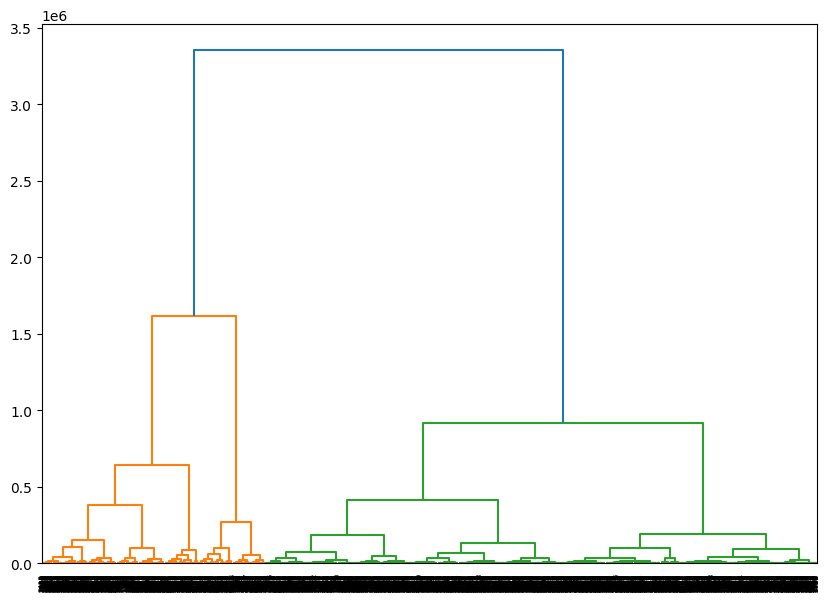

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

X = X_all_train_set.copy() # A new copy of data set
# Removing non-numerical columns
X = X.select_dtypes(include=[np.number])
# Replacing NaN values with median
X.fillna(X.median(), inplace=True)
X.head()

plt.figure(figsize=(10, 7))
dendrogram(linkage(X, method='ward'), orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

### Histogramme

Pour mieux visualiser les données, nous allons utiliser les histogrammes suivants :

Text(0.5, 0.98, 'Ethical train set')

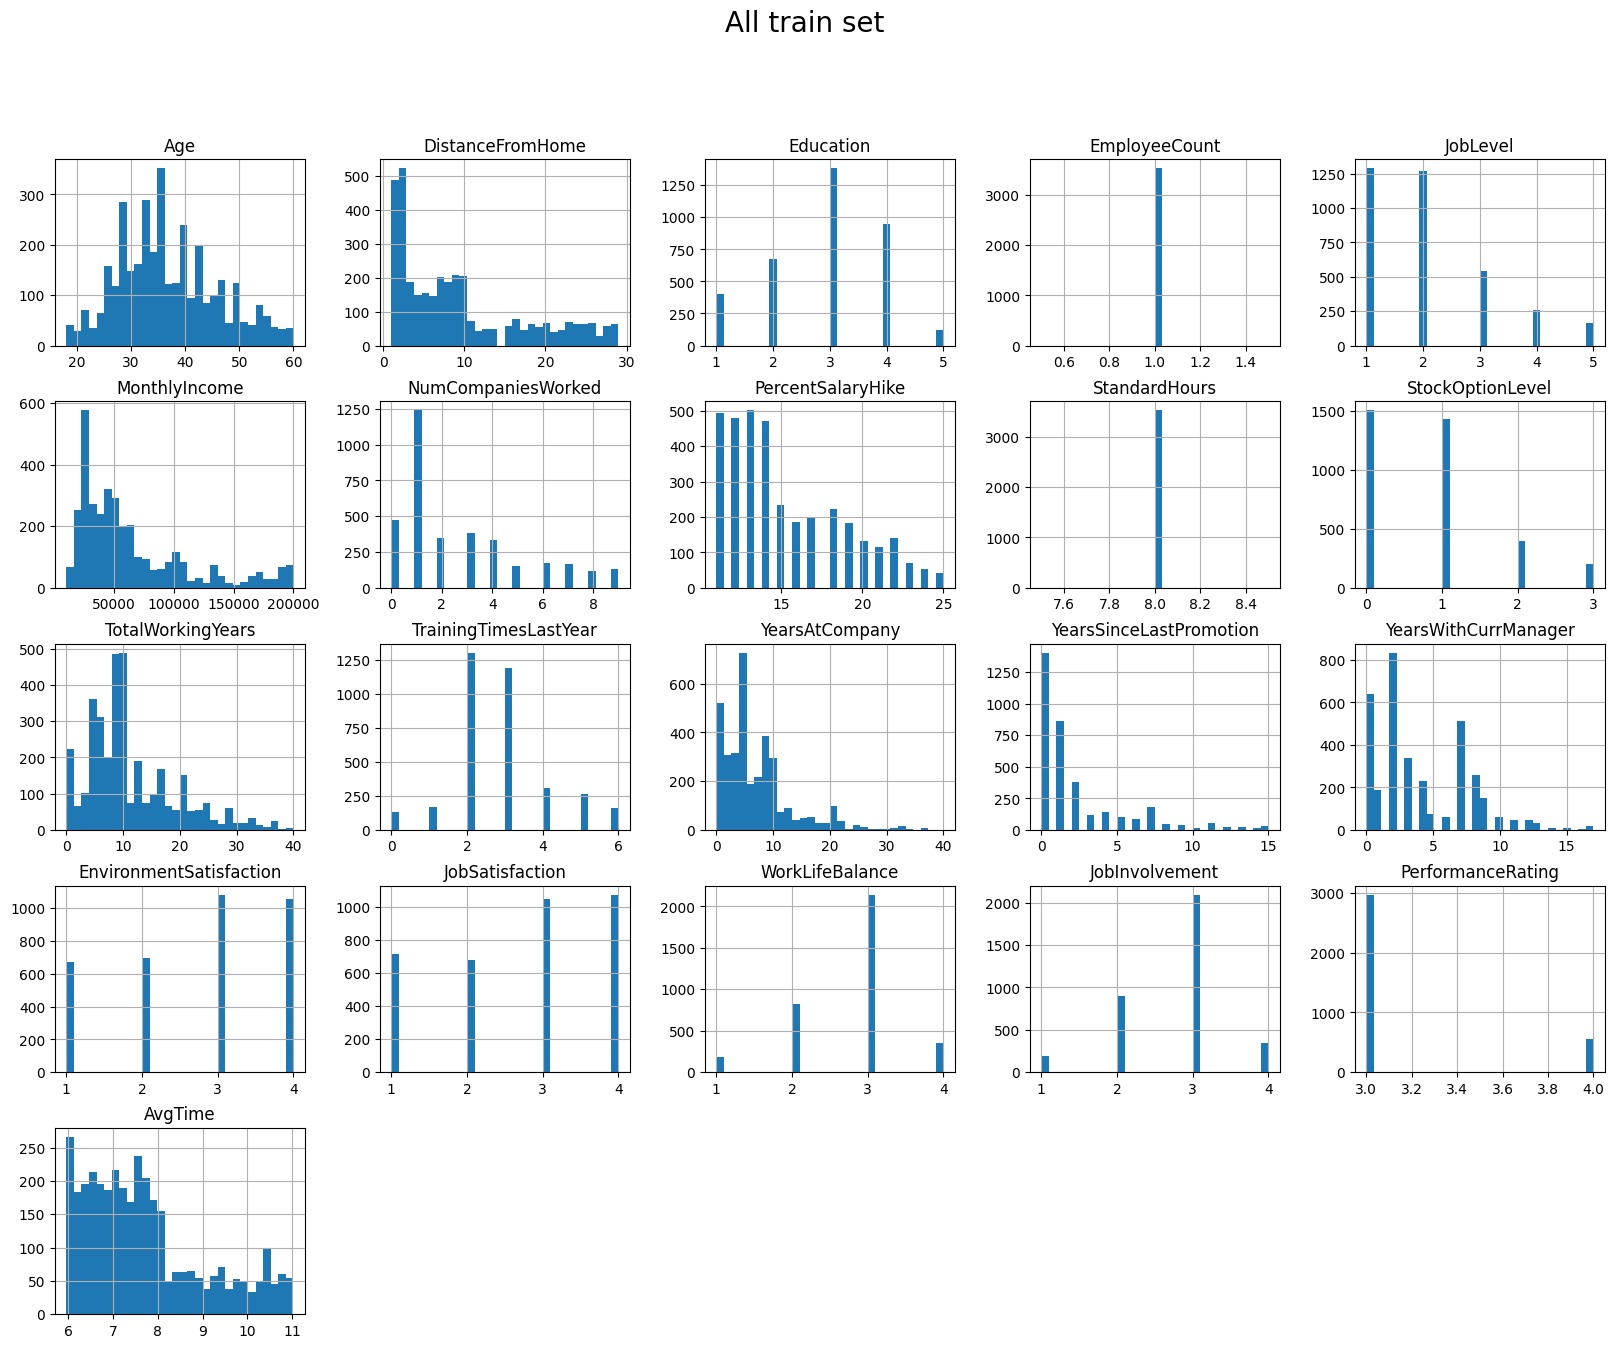

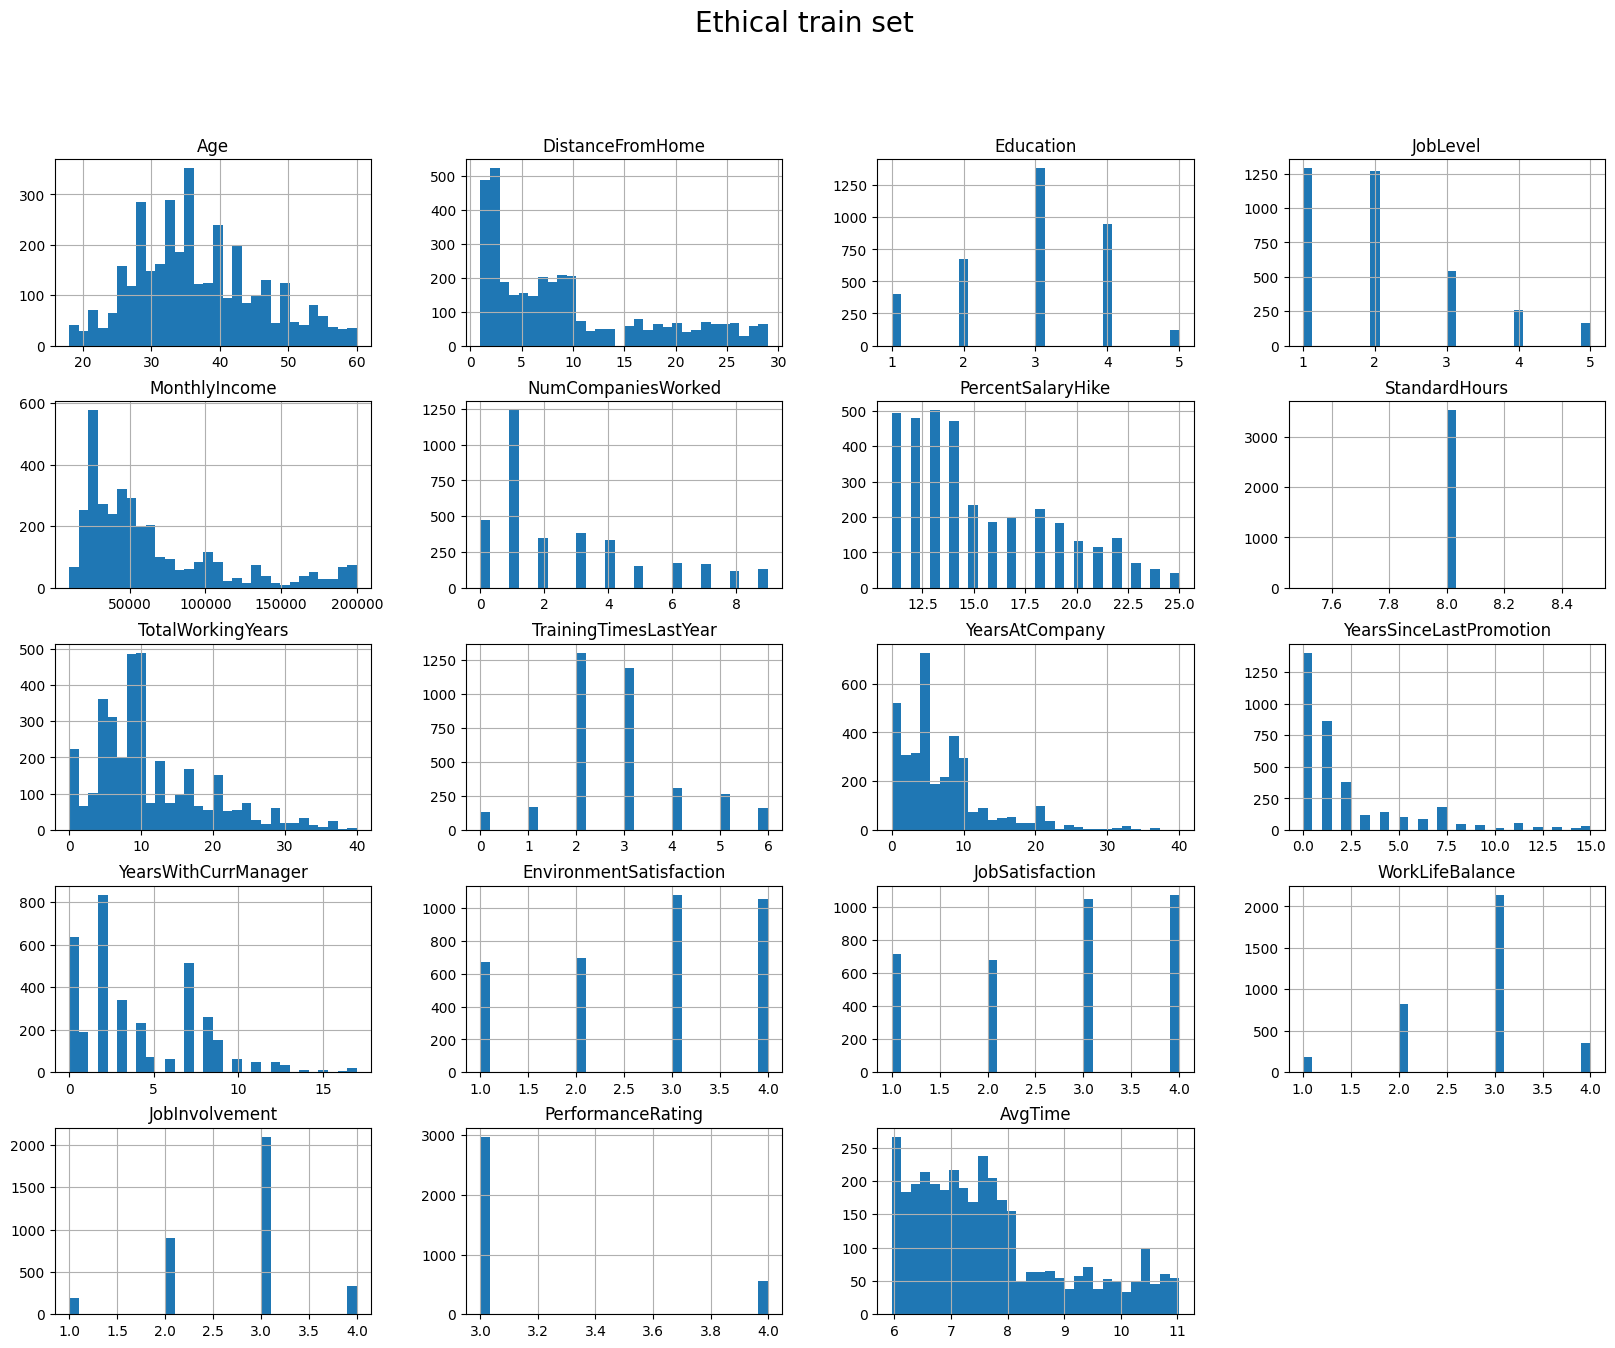

In [18]:
X_all_train_set.hist(bins=30, figsize=(20, 15))
plt.suptitle("All train set", fontsize=20)
X_ethical_train_set.hist(bins=30, figsize=(20, 15))
plt.suptitle("Ethical train set", fontsize=20)

### Corrélations

Pour cela nous allons croiser les variables entre elles et voir si elles sont corrélées. Le premier groupe de graphique est pour les variables du jeu non-éthique et le second pour les variables du jeu éthique.

Text(0.5, 0.98, 'Corrélation du jeu de données éthique')

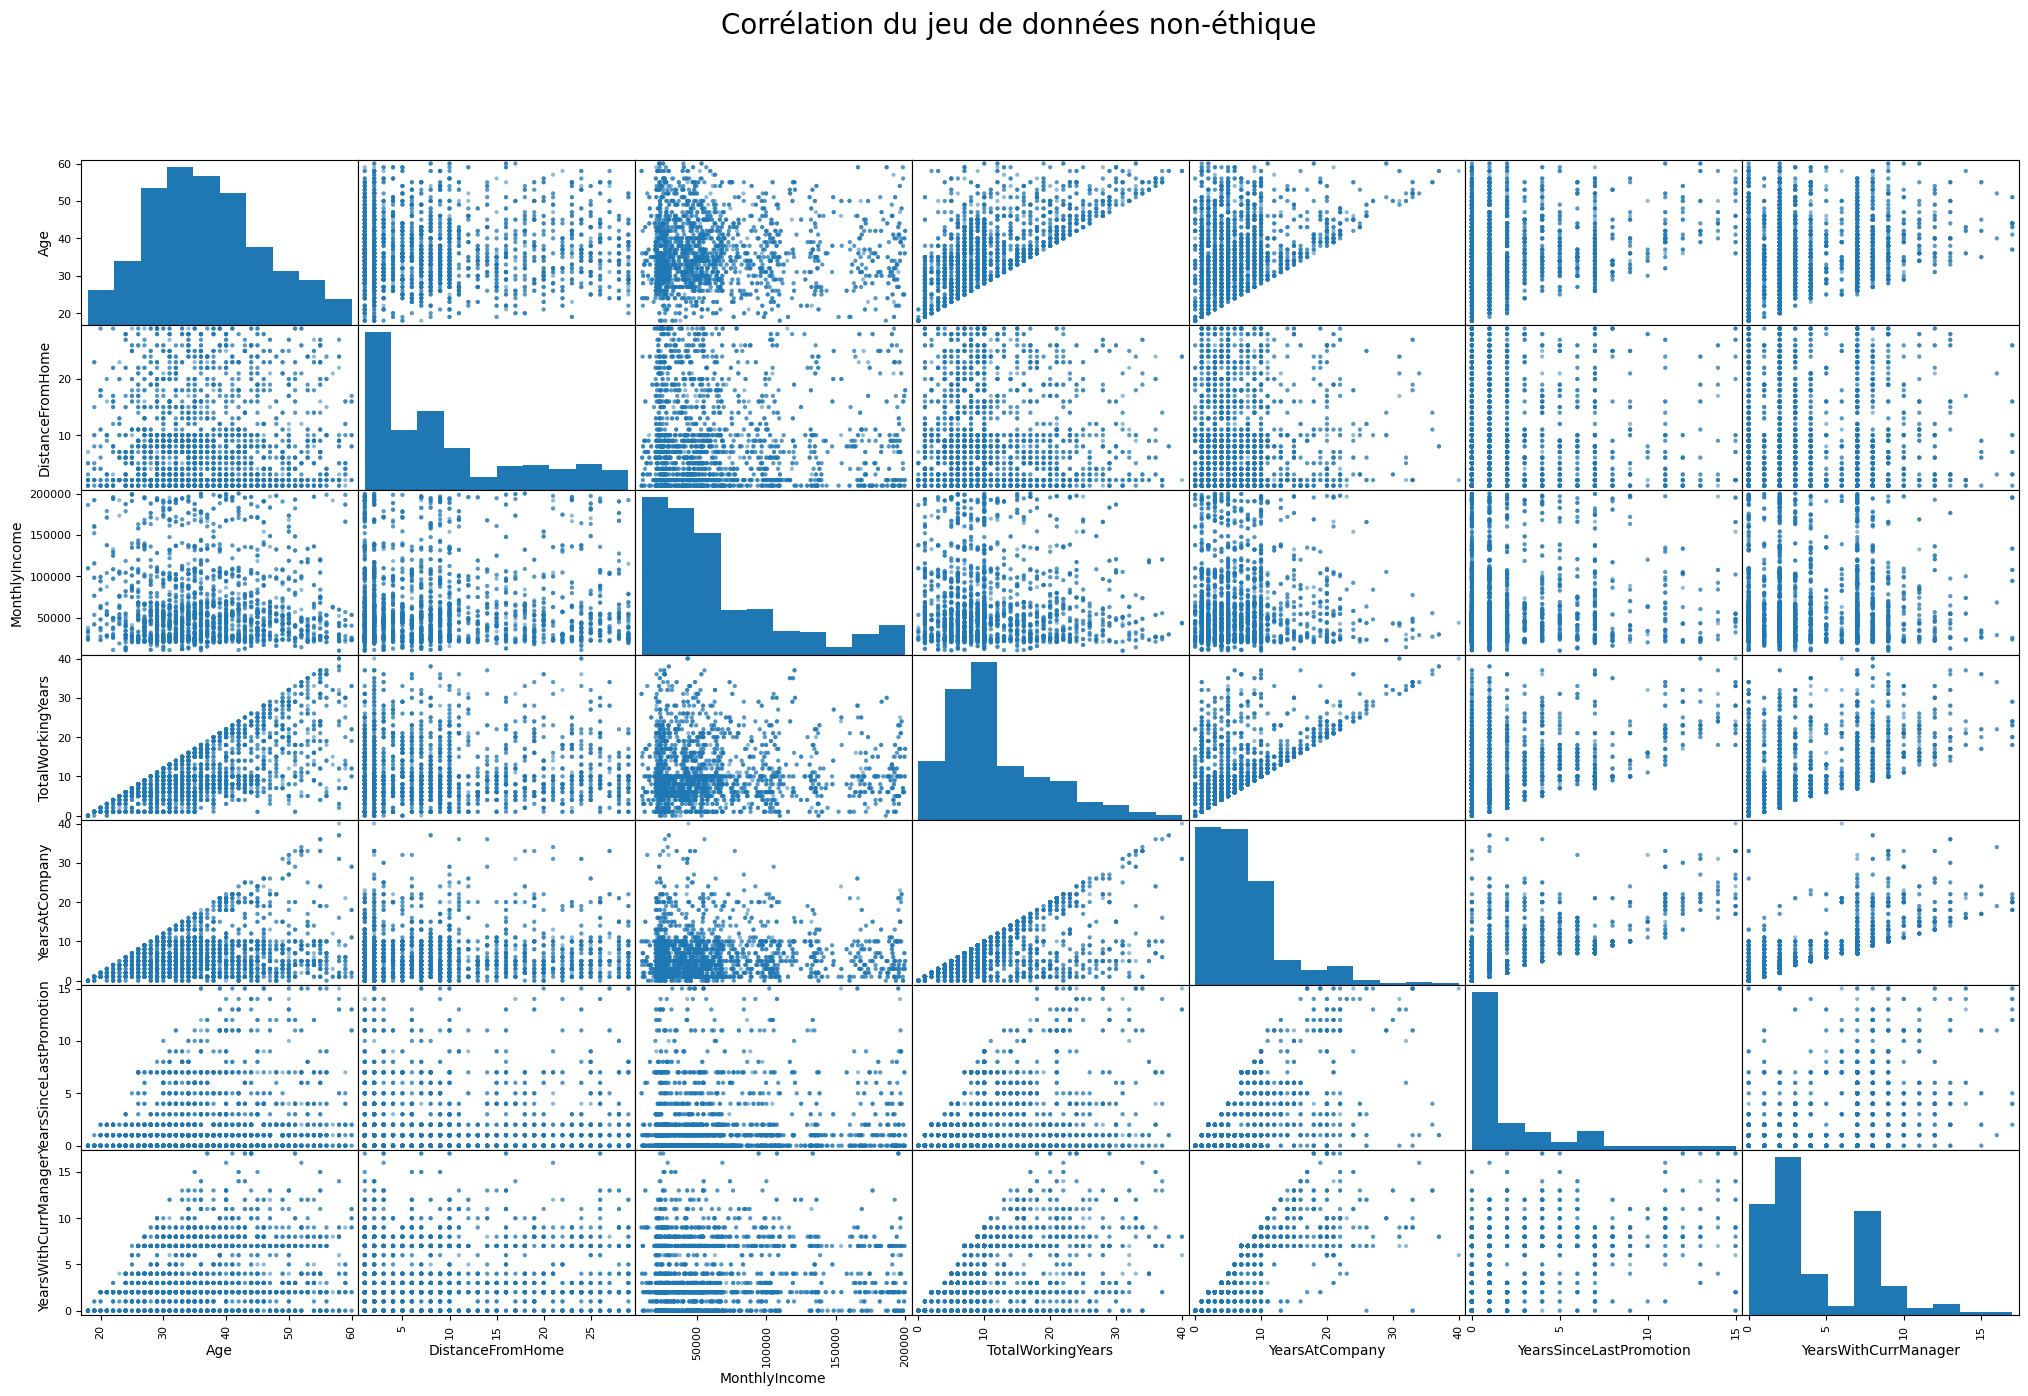

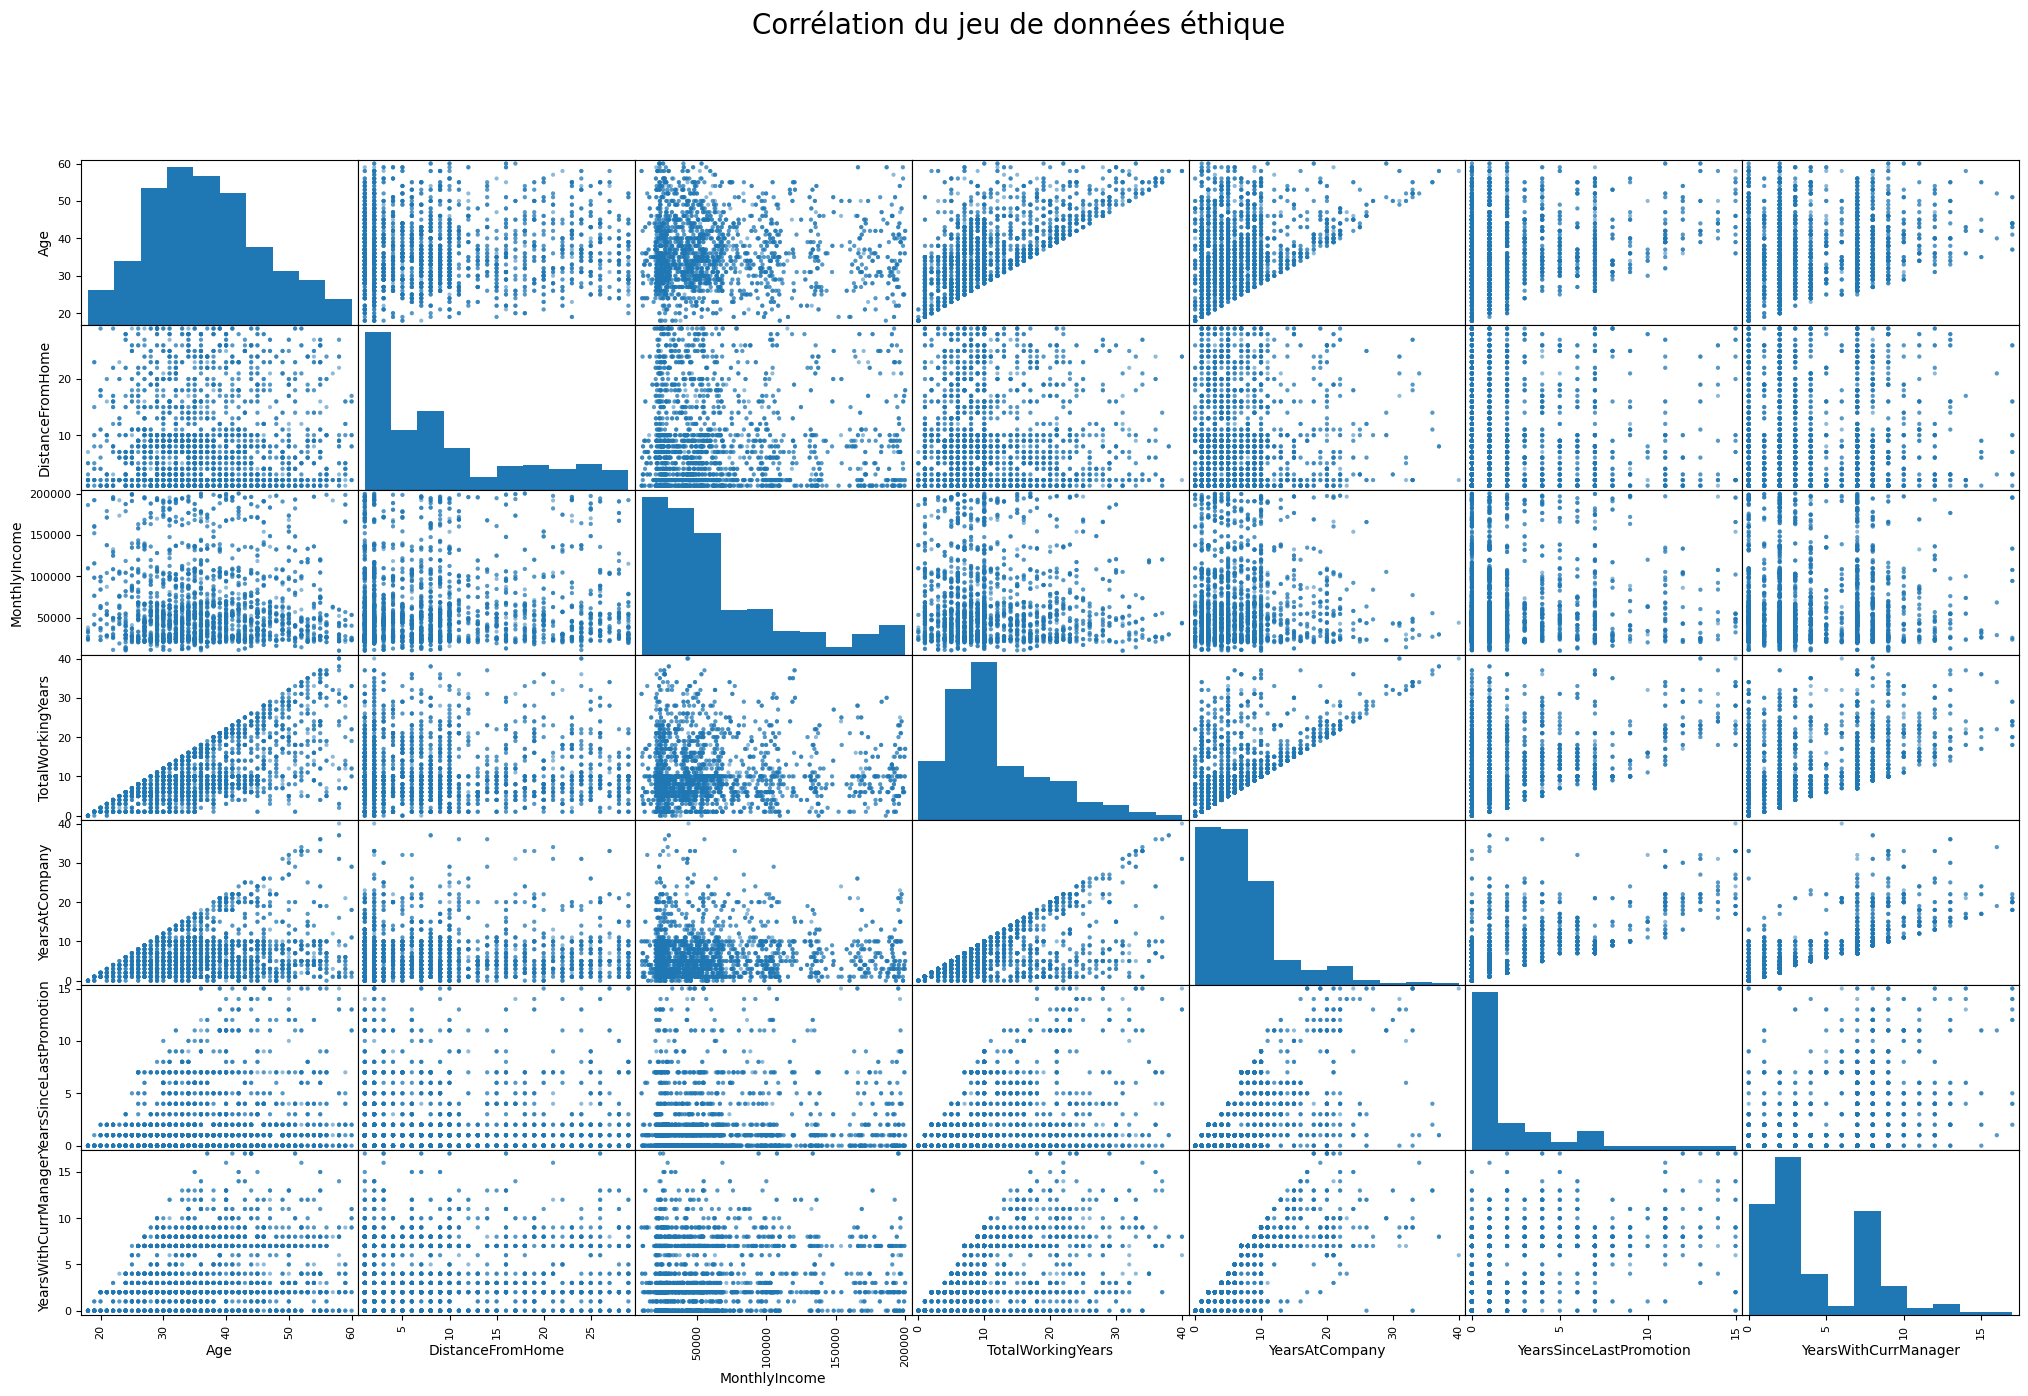

In [19]:
from pandas.plotting import scatter_matrix

# Selected attribut where foresee a correlation
attributes = ["Age", "DistanceFromHome", "MonthlyIncome", "TotalWorkingYears", "YearsAtCompany", "YearsSinceLastPromotion", "YearsWithCurrManager"]
scatter_matrix(X_all_train_set[attributes], figsize=(25, 15))
plt.suptitle("Corrélation du jeu de données non-éthique", fontsize=20)
scatter_matrix(X_ethical_train_set[attributes], figsize=(25, 15))
plt.suptitle("Corrélation du jeu de données éthique", fontsize=20)

Sur l'ensemble des graphiques ci-dessus, on peut voir une corrélation entre les variables suivantes :
* MonthlyWorkingYears et Age
* YearsAtCompany et Age
* YearsSinceLastPromotion et Age
* YearsWithCurrManager et Age
* TotalWorkingYears et YearsAtCompany
* TotalWorkingYears et YearSinceLastPromotion
* TotalWorkingYears et YearsWithCurrManager
* YearsAtCompany et YearsSinceLastPromotion
* YearsAtCompany et YearsWithCurrManager

On va vérifier avec le coefficient de corrélation de Pearson.

En premier pour le jeu de données non éthique :

In [20]:
# Pearson correlation
corr_matrix = X_all_train_set.corr()
corr_matrix["Age"].sort_values(ascending=False)

C:\Users\mathi\AppData\Local\Temp\ipykernel_4896\3432393514.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = X_all_train_set.corr()


Age                        1.000000
TotalWorkingYears          0.687479
YearsAtCompany             0.303995
NumCompaniesWorked         0.302573
YearsSinceLastPromotion    0.209991
YearsWithCurrManager       0.192375
JobInvolvement             0.024963
DistanceFromHome           0.020284
EnvironmentSatisfaction    0.015431
AvgTime                    0.004578
JobSatisfaction            0.003159
JobLevel                  -0.001795
WorkLifeBalance           -0.011611
PerformanceRating         -0.021689
PercentSalaryHike         -0.031440
Education                 -0.040497
StockOptionLevel          -0.040933
MonthlyIncome             -0.041327
TrainingTimesLastYear     -0.045376
EmployeeCount                   NaN
StandardHours                   NaN
Name: Age, dtype: float64

In [21]:
# Pearson correlation
corr_matrix = X_all_train_set.corr()
corr_matrix["TotalWorkingYears"].sort_values(ascending=False)

C:\Users\mathi\AppData\Local\Temp\ipykernel_4896\1832390085.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = X_all_train_set.corr()


TotalWorkingYears          1.000000
Age                        0.687479
YearsAtCompany             0.616246
YearsWithCurrManager       0.448549
YearsSinceLastPromotion    0.393249
NumCompaniesWorked         0.242085
WorkLifeBalance            0.009421
DistanceFromHome           0.007330
JobInvolvement             0.005107
EnvironmentSatisfaction    0.005013
PerformanceRating          0.000947
AvgTime                   -0.002424
StockOptionLevel          -0.002687
Education                 -0.005053
JobSatisfaction           -0.012441
PercentSalaryHike         -0.019499
MonthlyIncome             -0.027237
JobLevel                  -0.032583
TrainingTimesLastYear     -0.048444
EmployeeCount                   NaN
StandardHours                   NaN
Name: TotalWorkingYears, dtype: float64

En second temps sur le jeu de données éthique :

In [22]:
# Pearson correlation
corr_matrix = X_ethical_train_set.corr()
corr_matrix["Age"].sort_values(ascending=False)

C:\Users\mathi\AppData\Local\Temp\ipykernel_4896\3018483331.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = X_ethical_train_set.corr()


Age                        1.000000
TotalWorkingYears          0.687479
YearsAtCompany             0.303995
NumCompaniesWorked         0.302573
YearsSinceLastPromotion    0.209991
YearsWithCurrManager       0.192375
JobInvolvement             0.024963
DistanceFromHome           0.020284
EnvironmentSatisfaction    0.015431
AvgTime                    0.004578
JobSatisfaction            0.003159
JobLevel                  -0.001795
WorkLifeBalance           -0.011611
PerformanceRating         -0.021689
PercentSalaryHike         -0.031440
Education                 -0.040497
MonthlyIncome             -0.041327
TrainingTimesLastYear     -0.045376
StandardHours                   NaN
Name: Age, dtype: float64

In [23]:
# Pearson correlation
corr_matrix = X_ethical_train_set.corr()
corr_matrix["TotalWorkingYears"].sort_values(ascending=False)

C:\Users\mathi\AppData\Local\Temp\ipykernel_4896\183876214.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = X_ethical_train_set.corr()


TotalWorkingYears          1.000000
Age                        0.687479
YearsAtCompany             0.616246
YearsWithCurrManager       0.448549
YearsSinceLastPromotion    0.393249
NumCompaniesWorked         0.242085
WorkLifeBalance            0.009421
DistanceFromHome           0.007330
JobInvolvement             0.005107
EnvironmentSatisfaction    0.005013
PerformanceRating          0.000947
AvgTime                   -0.002424
Education                 -0.005053
JobSatisfaction           -0.012441
PercentSalaryHike         -0.019499
MonthlyIncome             -0.027237
JobLevel                  -0.032583
TrainingTimesLastYear     -0.048444
StandardHours                   NaN
Name: TotalWorkingYears, dtype: float64

On va donc créer des variables qui vont contenir la corrélation entre les variables :
* AgePerWorkingYears (Age / TotalWorkingYears)
* AgePerYarsAtCompany (Age / YearsAtCompany)
* AgePerNumCompaniesWorked (Age / NumCompaniesWorked)
* *AgePerYearsSinceLastPromotion (Age / YearsSinceLastPromotion)*
* *AgePerYearsWithCurrManager (Age / YearsWithCurrManager)*
* TotalWorkingYearsPerYearsAtCompany (TotalWorkingYears / YearsAtCompany)
* TotalWorkingYearsPerYearsWithCurrManager (TotalWorkingYears / YearsWithCurrManager)
* TotalWorkingYearsPerYearsSinceLastPromotion (TotalWorkingYears / YearsSinceLastPromotion)

# Pipeline de prétraitement


La pipeline fait référence à un ensemble d'étapes ou de processus qui sont exécutés séquentiellement pour traiter les données d'entrée, extraire des caractéristiques, entraîner le modèle et prédire les résultats.


## Nettoyage et normalisation

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """
    Class to add new columns to a dataframe from a list of columns to merge.

    Parameters
    ----------
    column_ids_to_merge : list[tuple[int]]
        List of tuples with the column ids to merge.

    Attributes
    ----------
    column_ids_to_merge : list[tuple[int]]
        List of tuples with the column ids to merge.

    Methods
    -------
    fit(X, y=None)
        Fit the model.

    transform(X, y=None)
        Transform the model.
    """

    def __init__(self, attribs_name_to_merge=[]):
        """
        Init the class.

        Parameters
        ----------
        column_ids_to_merge : list[tuple[int]]
            List of tuples with the column ids to merge.

        Returns
        -------
        None
        """
        self.attribs_name_to_merge = attribs_name_to_merge

    def fit(self, X=None, y=None):
        """
        Fit the model.

        Parameters
        ----------
        X : pandas.DataFrame
            The data to fit the model.

        y : pandas.DataFrame
            The target to fit the model.
            default: None

        Returns
        -------
        self
        """
        return self  # nothing else to do

    def transform(self, X, y=None):
        """
        Transform the model.

        Parameters
        ----------
        X : pandas.DataFrame
            The data to transform the model.

        y : pandas.DataFrame
            The target to transform the model.
            default: None

        Returns
        -------
        numpy.ndarray
            The transformed data.
        """
        if len(self.attribs_name_to_merge) == 0:
            return X
        for ctm in self.attribs_name_to_merge:
            # index1 * index2
            X["%sPer%s" % (ctm[0], ctm[1])] = X[ctm[0]] * X[ctm[1]]
        return X

    def set_output(self, transform):
        """
        Set the output of the model. But here we don't need it because the output is the same as the input.

        Parameters
        ----------
        output : numpy.ndarray
            The output of the model.

        Returns
        -------
        None
        """
        pass


In [25]:
# List of columns to merge to add columns
columns_to_merge = [
    ("TotalWorkingYears", "Age"),
    ("YearsAtCompany", "Age"),
    ("NumCompaniesWorked", "Age"),
    ("YearsSinceLastPromotion", "Age"),
    ("YearsWithCurrManager", "Age"),
    ("YearsAtCompany", "TotalWorkingYears"),
    ("YearsSinceLastPromotion", "TotalWorkingYears"),
    ("YearsWithCurrManager", "TotalWorkingYears"),
]


In [26]:
# Create the pipeline for numerical attributes
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder(columns_to_merge)),
    ('std_scaler', StandardScaler()),
]).set_output(transform="pandas")


In [27]:
# Full pipeline
full_pipeline = ColumnTransformer(transformers=[
    ("num", num_pipeline, lambda x: x.select_dtypes(include=[np.number]).columns),
    ("cat", OneHotEncoder(sparse_output=False), lambda x: x.select_dtypes(exclude=[np.number]).columns),
], remainder='passthrough').set_output(transform="pandas")


In [28]:
# -- All --
X_all_train_set_prepared = full_pipeline.fit_transform(
    X_all_train_set)
# -- Ethical --
X_ethical_train_set_prepared = full_pipeline.fit_transform(
    X_ethical_train_set)


In [29]:
X_all_train_set_prepared


num__Age  num__DistanceFromHome  num__Education  num__EmployeeCount  \
3465  0.463140              -1.016618         1.05518                 0.0   
3485 -0.306868              -1.016618        -1.87606                 0.0   
3052 -1.736884               0.087413        -0.89898                 0.0   
2012 -0.966876              -0.280597         0.07810                 0.0   
426   0.353139              -1.016618         1.05518                 0.0   
...        ...                    ...             ...                 ...   
743   0.023135               1.314114         2.03226                 0.0   
613  -1.406880               2.295474         1.05518                 0.0   
808  -0.416870              -0.280597        -0.89898                 0.0   
2946 -0.966876               0.210083        -0.89898                 0.0   
1125 -0.086866              -1.016618         0.07810                 0.0   

      num__JobLevel  num__MonthlyIncome  num__NumCompaniesWorked  \
3465      -0.969757           -0.259638                -0.679818   
3485      -0.068228           -0.801808                 0.119915   
3052      -0.969757           -0.235080                -0.679818   
2012      -0.068228           -0.742531                -0.679818   
426       -0.068228            2.698904                -0.279952   
...             ...                 ...                      ...   
743       -0.068228            0.067866                 0.519781   
613        0.833301           -0.761584                -0.679818   
808       -0.068228           -0.581425                 2.119247   
2946      -0.068228           -0.141931                -0.279952   
1125      -0.068228           -0.771746                -0.679818   

      num__PercentSalaryHike  num__StandardHours  num__StockOptionLevel  \
3465               -0.341374                 0.0              -0.939036   
3485                2.102113                 0.0              -0.939036   
3052               -0.884371                 0.0               0.234094   
2012               -0.341374                 0.0              -0.939036   
426                -0.341374                 0.0               0.234094   
...                      ...                 ...                    ...   
743                -0.612873                 0.0               0.234094   
613                 1.016119                 0.0               0.234094   
808                 1.830614                 0.0               1.407223   
2946                1.287617                 0.0               0.234094   
1125                1.016119                 0.0               1.407223   

      num__TotalWorkingYears  num__TrainingTimesLastYear  num__YearsAtCompany  \
3465               -0.160786                   -0.615667             0.508815   
3485               -0.676822                    0.162575            -1.149782   
3052               -1.321867                   -0.615667            -0.983923   
2012               -1.321867                    0.162575            -0.983923   
426                -0.031777                    0.162575            -0.983923   
...                      ...                         ...                  ...   
743                -0.418804                   -1.393910            -0.652203   
613                -1.321867                    1.719060            -0.983923   
808                -0.418804                   -0.615667            -0.320484   
2946               -0.805831                   -0.615667            -1.149782   
1125               -0.805831                    1.719060            -0.320484   

      num__YearsSinceLastPromotion  num__YearsWithCurrManager  \
3465                     -0.677208                   1.098882   
3485                     -0.677208                  -1.146292   
3052                     -0.677208                  -1.146292   
2012                     -0.677208                  -1.146292   
426                      -0.677208                  -1.146292   


In [30]:
X_ethical_train_set_prepared


num__Age  num__DistanceFromHome  num__Education  num__JobLevel  \
3465  0.463140              -1.016618         1.05518      -0.969757   
3485 -0.306868              -1.016618        -1.87606      -0.068228   
3052 -1.736884               0.087413        -0.89898      -0.969757   
2012 -0.966876              -0.280597         0.07810      -0.068228   
426   0.353139              -1.016618         1.05518      -0.068228   
...        ...                    ...             ...            ...   
743   0.023135               1.314114         2.03226      -0.068228   
613  -1.406880               2.295474         1.05518       0.833301   
808  -0.416870              -0.280597        -0.89898      -0.068228   
2946 -0.966876               0.210083        -0.89898      -0.068228   
1125 -0.086866              -1.016618         0.07810      -0.068228   

      num__MonthlyIncome  num__NumCompaniesWorked  num__PercentSalaryHike  \
3465           -0.259638                -0.679818               -0.341374   
3485           -0.801808                 0.119915                2.102113   
3052           -0.235080                -0.679818               -0.884371   
2012           -0.742531                -0.679818               -0.341374   
426             2.698904                -0.279952               -0.341374   
...                  ...                      ...                     ...   
743             0.067866                 0.519781               -0.612873   
613            -0.761584                -0.679818                1.016119   
808            -0.581425                 2.119247                1.830614   
2946           -0.141931                -0.279952                1.287617   
1125           -0.771746                -0.679818                1.016119   

      num__StandardHours  num__TotalWorkingYears  num__TrainingTimesLastYear  \
3465                 0.0               -0.160786                   -0.615667   
3485                 0.0               -0.676822                    0.162575   
3052                 0.0               -1.321867                   -0.615667   
2012                 0.0               -1.321867                    0.162575   
426                  0.0               -0.031777                    0.162575   
...                  ...                     ...                         ...   
743                  0.0               -0.418804                   -1.393910   
613                  0.0               -1.321867                    1.719060   
808                  0.0               -0.418804                   -0.615667   
2946                 0.0               -0.805831                   -0.615667   
1125                 0.0               -0.805831                    1.719060   

      num__YearsAtCompany  num__YearsSinceLastPromotion  \
3465             0.508815                     -0.677208   
3485            -1.149782                     -0.677208   
3052            -0.983923                     -0.677208   
2012            -0.983923                     -0.677208   
426             -0.983923                     -0.677208   
...                   ...                           ...   
743             -0.652203                     -0.677208   
613             -0.983923                     -0.677208   
808             -0.320484                     -0.677208   
2946            -1.149782                     -0.677208   
1125            -0.320484                     -0.677208   

      num__YearsWithCurrManager  num__EnvironmentSatisfaction  \
3465                   1.098882                     -0.661977   
3485                  -1.146292                      0.257856   
3052                  -1.146292                      0.257856   
2012                  -1.146292                     -1.581810   
426                   -1.146292                     -1.581810   
...                         ...                           ...   
743                   -0.584999                     -1.581810   
613                   -1.1

In [31]:
# Delete to free memory
del columns_to_merge
del df_all
del df_ethical

### Réduction de la dimensionnalité


##### Analyse en composantes principales


In [32]:
import time
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


def plot_feature_importances(X: pd.DataFrame, y: pd.DataFrame, title: str):
    """
    Plot the feature importances.

    Parameters
    ----------
    X : pandas.DataFrame
        The data to plot the feature importances.

    y : pandas.DataFrame
        The target to plot the feature importances.

    title : str
        The title of the plot.

    Returns
    -------
    None
    """
    feature_names = X.columns
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X, y)

    start_time = time.time()
    importances = forest.feature_importances_
    std = np.std(
        [tree.feature_importances_ for tree in forest.estimators_], axis=0)
    elapsed_time = time.time() - start_time

    print(
        f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
    forest_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title(title)
    ax.set_ylabel("Mean decrease in impurity")
    fig.set_size_inches(10, 10)
    # Draw line at 0.01 threshold
    ax.axhline(y=0.01, linestyle='--', color='r')
    fig.tight_layout()


Elapsed time to compute the importances: 0.006 seconds


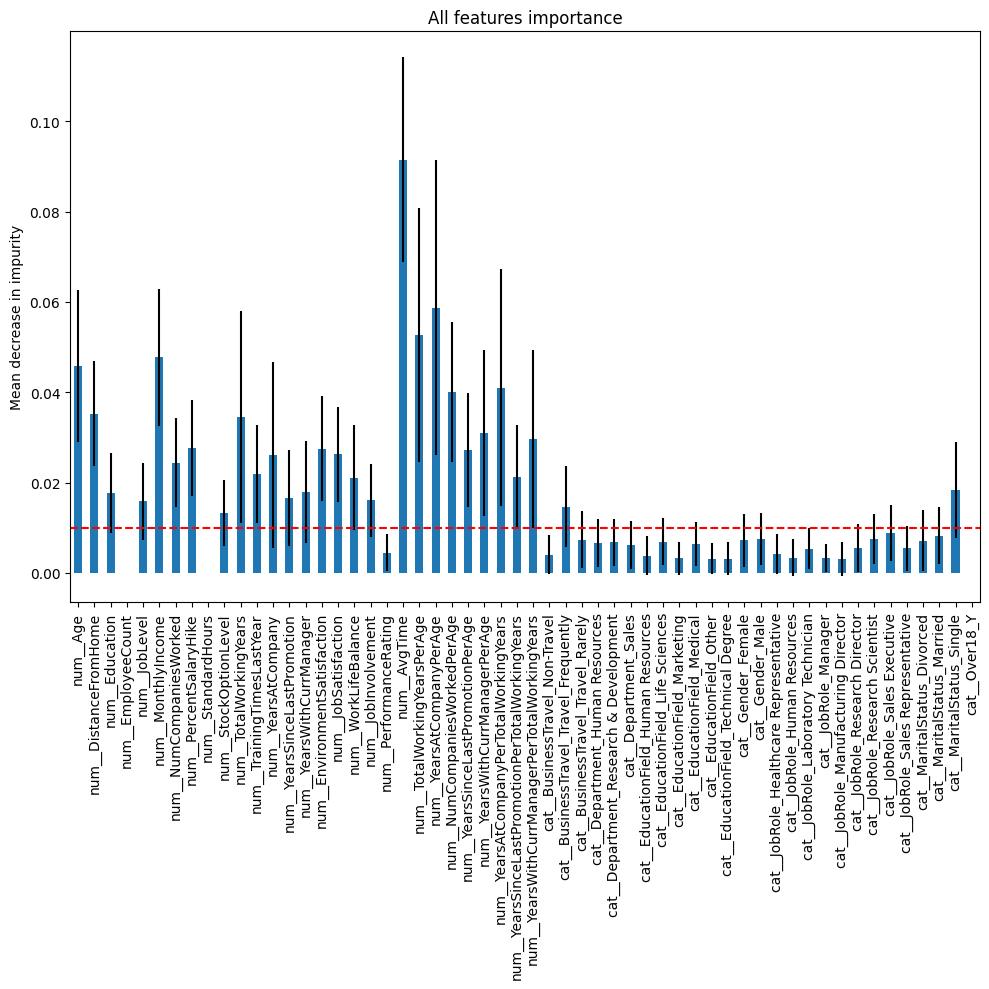

In [33]:
plot_feature_importances(X_all_train_set_prepared,
                         y_all_train_set, "All features importance")

Elapsed time to compute the importances: 0.011 seconds


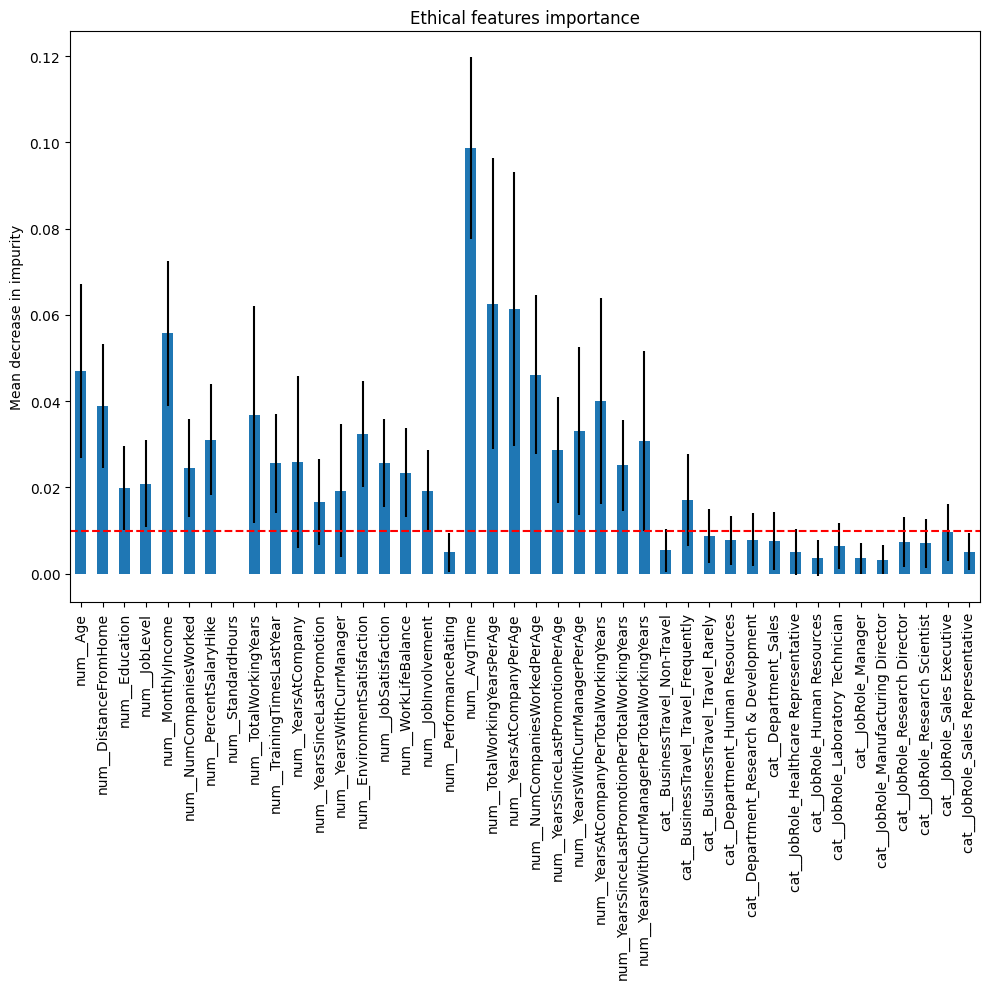

In [34]:
plot_feature_importances(X_ethical_train_set_prepared,
                         y_ethical_train_set, "Ethical features importance")

| <p align="center"> <img src="./img/with_feature_importance.png" style="max-width: 100%"/> <p align="center">Figure 1 : Utilisation de ML après réduction de la dimensionnalité avec features_importance </p></p> | <p align="center"> <img src="./img/without_feature_importance.png" style="max-width: 100%"/> <p align="center">Figure 2 : Utilisation de ML après réduction de la dimensionnalité sans features_importance </p></p> |
| :--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |


Comme on peut le voir sur les figures 1 et 2, l'utilisation de la réduction de la dimensionnalité ne change pas grand chose. Cela est dû au fait que les données sont déjà très peu nombreuses (environ 3000 lignes) et que la réduction de la dimensionnalité ne permet pas de réduire le nombre de variables à un nombre suffisant pour que le modèle puisse être entraîné correctement.


##### Utilisation de l'ACP


In [35]:
from sklearn.decomposition import PCA


def plot_pca(df: pd.DataFrame, pca_dim_size: int):
    """
    Plot the PCA graph to see the number of components to keep.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe to plot.

    pca_dim_size : int
        The number of components to keep.

    Returns
    -------
    None
    """
    # Instanciation de la classe PCA
    pca = PCA()

    # Calcul des composantes principales
    pca.fit(df)

    # Création du graphique de variance expliquée
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Nombre de composantes principales')
    plt.ylabel('Variance expliquée')
    # Ajouter une ligne verticale pour montrer le nombre de composantes principales
    plt.axvline(x=pca_dim_size, color='r', linestyle='--')
    # Changer les borne de l'axe des x
    plt.xlim(0, 30, 5)
    plt.show()


pca_dim_size = 17

C:\Users\mathi\AppData\Local\Temp\ipykernel_4896\1443146232.py:33: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0, 30, 5)


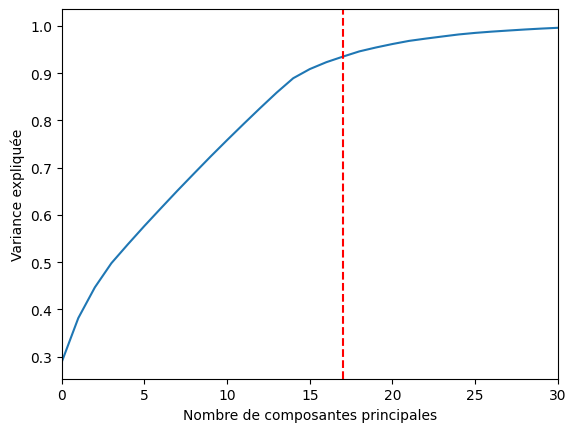

In [36]:
plot_pca(X_ethical_train_set_prepared, pca_dim_size)


C:\Users\mathi\AppData\Local\Temp\ipykernel_4896\1443146232.py:33: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0, 30, 5)


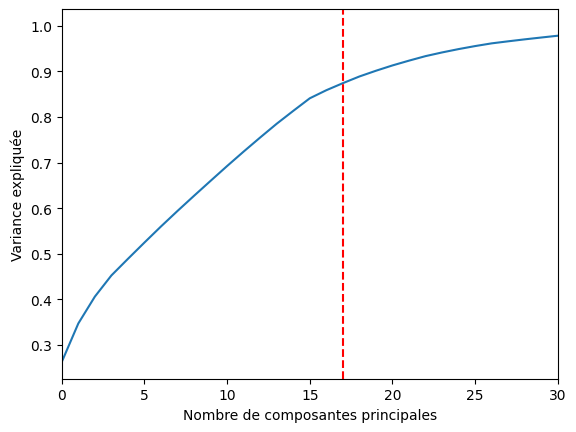

In [37]:
plot_pca(X_all_train_set_prepared, pca_dim_size)


Pour les 2 jeux de données, la réduction de la dimentionnalité semble adaptée. Pour cela, nous allons utiliser l'ACP. Grace au graphique ci-dessus, nous pouvons voir que les 2 jeux de données sont très proches. Nous allons donc utiliser le même nombre de composantes pour les 2 jeux de données : **17**.

Cependant, après essais avec et sans réduction de la dimensionnalité, nous avons constaté que la réduction de la dimensionnalité n'améliorait pas la qualité du modèle voir la réduisait. Nous allons donc utiliser les données sans réduction de la dimensionnalité.

| <p align="center"><img src="./img/with_pca_19.png" style="max-width: 100%"/><p align="center">Figure 3 : Avec ACP (19 composantes)</p></p> | <p align="center"><img src="./img/with_pca_24.png" style="max-width: 100%"/><p align="center">Figure 4 : Avec ACP (24 composantes)</p></p> |
| :----------------------------------------------------------------------------------------------------------------------------------------: | :----------------------------------------------------------------------------------------------------------------------------------------: |

<p align="center">
<img src="./img/without_pca.png" style="max-width: 100%"/>
<p align="center"><b>Figure 5 : Sans ACP</b></p>
</p>


## Préparation des jeux de train et test


In [38]:
X_all_train_set_prepared = full_pipeline.fit_transform(
    X_all_train_set)

In [39]:
X_all_test_set_prepared = full_pipeline.fit_transform(
    X_all_test_set)

In [40]:
X_ethical_train_set_prepared = full_pipeline.fit_transform(
    X_ethical_train_set)

In [41]:
X_ethical_test_set_prepared = full_pipeline.fit_transform(
    X_ethical_test_set)

In [42]:
from sklearn.preprocessing import LabelEncoder

# Instantiate label encoder
label_encoder = LabelEncoder()

In [43]:
y_ethical_train_prepared = label_encoder.fit_transform(y_ethical_train_set)


In [44]:
y_ethical_test_prepared = label_encoder.fit_transform(y_ethical_test_set)


In [45]:
y_all_train_prepared = label_encoder.fit_transform(y_all_train_set)


In [ ]:
y_all_test_prepared = label_encoder.fit_transform(y_all_test_set)


# Sauvegarde du jeu de données


In [ ]:
import pickle

# Save data
path_data = "./data/prepared_data/"
path_ethical = path_data + "ethical/"
path_all = path_data + "all/"

# make directory if not exists
if not os.path.exists(path_data):
    os.makedirs(path_data)
if not os.path.exists(path_ethical):
    os.makedirs(path_ethical)
if not os.path.exists(path_all):
    os.makedirs(path_all)

# -- All --
# Train set
with open(path_all + "X_all_train.pkl", "wb") as f:
    pickle.dump(X_all_train_set_prepared, f)
with open(path_all + "Y_all_train.pkl", "wb") as f:
    pickle.dump(y_all_train_prepared, f)
# Test set
with open(path_all + "X_all_test.pkl", "wb") as f:
    pickle.dump(X_all_test_set_prepared, f)
with open(path_all + "Y_all_test.pkl", "wb") as f:
    pickle.dump(y_all_test_prepared, f)

# -- Ethical --
# Train set
with open(path_ethical + "X_ethical_train.pkl", "wb") as f:
    pickle.dump(X_ethical_train_set_prepared, f)
with open(path_ethical + "Y_ethical_train.pkl", "wb") as f:
    pickle.dump(y_ethical_train_prepared, f)
# Test set
with open(path_ethical + "X_ethical_test.pkl", "wb") as f:
    pickle.dump(X_ethical_test_set_prepared, f)
with open(path_ethical + "Y_ethical_test.pkl", "wb") as f:
    pickle.dump(y_ethical_test_prepared, f)


# Utilisation du Machine Learning

Le machine learning est une branche de l'intelligence artificielle qui permet aux machines d'apprendre à partir des données. Il existe plusieurs types de machine learning : le machine learning supervisé, le machine learning non-supervisé et le machine learning semi-supervisé. Dans notre cas, nous allons utiliser le machine learning supervisé.

* Pour voir plus en détail l'exécution sur le jeu de données éthique, voir le notebook [Machine Learning Éthique](./algo_ml_ethical.ipynb).
* Pour voir plus en détail l'exécution sur le jeu de données non éthique, voir le notebook [Machine Learning Non Éthique](./algo_ml_all.ipynb).

## Comparaison des résultats sur les jeux de données éthique et non éthique

Ces deux jeux de données ont été créés à partir du même jeu de données. Le seul changement est que le jeu de données éthique a été créé en utilisant les données éthiques et le jeu de données non éthique a été créé en utilisant toutes les données. Nous allons donc comparer les résultats obtenus sur ces deux jeux de données.

|<p align="center"><img src="./img/prt_ethical.png" style="max-width: 100%"/><p align="center">Figure 6 : Courbe Précision-Rappel / Seuil pour le jeu de données éthique</p></p>|<p align="center"><img src="./img/prt_all.png" style="max-width: 100%"/><p align="center">Figure 7 : Courbe Précision-Rappel / Seuil pour le jeu de données non éthique</p></p>|
|:--:|:--:|

On remarque, en comparant les résultats du jeu de données éthique avec le jeu de donnée non éthique. On remarque que le jeu de données éthique donne des résultats légèrement moins bons que le jeu de données non éthique. 

Cette impact est négligeable étant donné les hautes performances de notre modèle. Prendre en compte l'éthique n'est donc pas un handicap pour le modèle qui donnera des résultats très similaires.